In [80]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.cm as cm
from scipy.stats import zscore
from scipy import stats


- Perform the data cleaning 

In [81]:
df = pd.read_excel(r'data\Purchase_Sale.xlsx')

# changing the datatype of vendorname and Description column to string
df['Vendor_Name'] = df['Vendor_Name'].astype('string')
df['Description'] = df['Description'].astype('string')

# strip the string column to remove unwanted space
df['Description'] = df['Description'].str.strip()
df['Vendor_Name'] = df['Vendor_Name'].str.strip()

# checking for the null values
df.isnull().sum()

# filling all the nan values
df.fillna(0 , inplace = True)

- Calculate useful kpi

In [82]:
# Calculating importent performance metrics 

# the unsold items
df['Unsold_Inv'] =  df['Quantity_purchased'] - df['Quantity_Sold']

# Selling price to cost price
df['Sale_to_Purchase_ratio'] =  df['Total_Selling_Price'] / df['Total_Cost_price']

# Gross profit
df['Gross_Profit'] = df['Total_Selling_Price'] - df['Total_Cost_price'] - df['Tax']

# profit margin
df['Profit_Margin'] = (df['Gross_Profit'] / df['Total_Selling_Price']) * 100

# Ratio of goods sold to purchased
df['Stock_turnover'] = df['Quantity_Sold'] / df['Quantity_purchased']



- Look at the statistics of the data, using the describe method

In [83]:
# Data statistics
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Brand,10648.0,1.805450e+04,12643.196784,58.00,5816.500000,18776.500000,25521.250000,9.063100e+04
Vendor_Number,10648.0,1.064071e+04,18700.404409,2.00,3943.500000,7153.000000,9552.000000,1.733570e+05
Quantity_purchased,10648.0,3.145160e+03,11113.367455,1.00,36.000000,261.000000,1981.250000,3.376600e+05
Cost_price,10648.0,2.440210e+01,109.483355,0.36,6.840000,10.450000,19.470000,5.681810e+03
Total_Cost_price,10648.0,3.013816e+04,123277.154715,0.71,452.857500,3646.725000,20764.170000,3.811252e+06
Quantity_Sold,10648.0,3.081902e+03,10971.073340,0.00,33.000000,260.500000,1934.250000,3.349390e+05
Selling_price,10648.0,3.567118e+01,148.534066,0.49,10.990000,15.990000,28.990000,7.499990e+03
Total_Selling_Price,10648.0,4.230292e+04,167947.264974,0.00,728.275000,5285.915000,28414.050000,5.101920e+06
Tax,10648.0,1.775334e+03,10992.438862,0.00,4.800000,46.355000,418.375000,3.682428e+05
Transportation_Cost,10648.0,6.148172e+04,61024.808162,0.27,14069.870000,50293.620000,79528.990000,2.570321e+05


**Outliers and Anomaly detection**
- visualize using the box plot

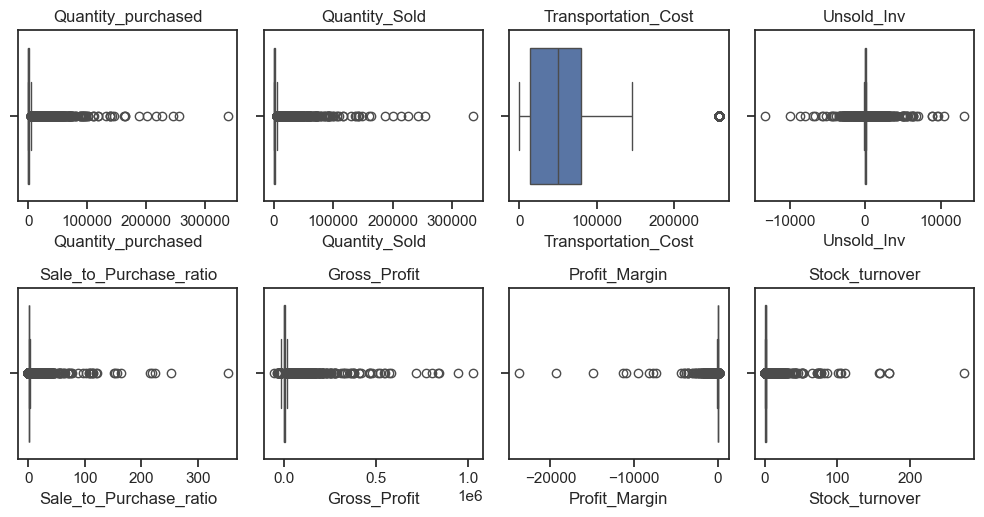

In [84]:
cols_to_plot = ['Quantity_purchased', 'Quantity_Sold', 'Transportation_Cost', 'Unsold_Inv', 'Sale_to_Purchase_ratio', 'Gross_Profit', 'Profit_Margin', 'Stock_turnover']

sns.set_theme(style='ticks')

plt.figure(figsize=(10, 10))

for i, col in enumerate(cols_to_plot, 1):
    plt.subplot(4, 4, i)
    sns.boxplot(x=df[col])
    # sns.histplot(x = df[col], kde = True, bins = 30 )
    plt.title(col)

plt.tight_layout()
plt.show()

In [85]:
#filtering the dataset, to reduce outliers
df_clean = df[(df['Gross_Profit'] > 0) & (df['Profit_Margin'] > 0) & (df['Quantity_Sold'] > 0)].copy()

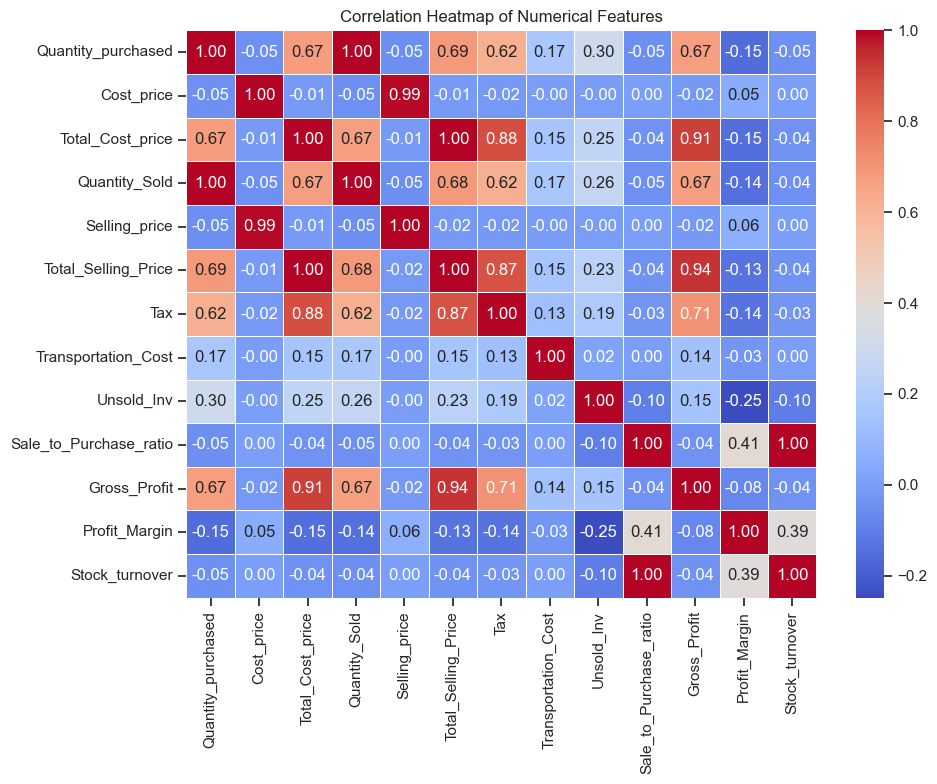

In [86]:
# Showing the correlation between different columns, using heatmap

num_cols = [
    'Quantity_purchased',     
    'Cost_price',                
    'Total_Cost_price', 
    'Quantity_Sold',        
    'Selling_price',        
    'Total_Selling_Price',
    'Tax',           
    'Transportation_Cost', 
    'Unsold_Inv',     
    'Sale_to_Purchase_ratio',
    'Gross_Profit',        
    'Profit_Margin', 
    'Stock_turnover'              
]

corr_matrix = df_clean[num_cols].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap of Numerical Features")
plt.tight_layout()
plt.show()


- 	Identify Brands that needs promotional or pricing adjustments which exhibits lower sales performance but higher profit margins


In [87]:
df_brand = df_clean.groupby('Brand').agg({
    'Total_Selling_Price': 'sum',
    'Profit_Margin': 'mean',
    'Gross_Profit': 'sum'
}).reset_index()

q1_sales = df_brand['Total_Selling_Price'].quantile(0.15) 
q3_margin = df_brand['Profit_Margin'].quantile(0.85)

promo_brands = df_brand[
    (df_brand['Total_Selling_Price'] <= q1_sales) &
    (df_brand['Profit_Margin'] >= q3_margin)
]

In [88]:
promo_brands

,Brand,Total_Selling_Price,Profit_Margin,Gross_Profit
23,122,252.77,89.670451,226.66
75,267,77.94,65.255325,50.86
106,363,483.78,81.127785,392.48
356,926,167.94,72.680719,122.06
363,935,199.95,67.956989,135.88
...,...,...,...,...
8292,45495,508.68,82.979476,422.10
8333,45993,142.87,80.821726,115.47
8352,46135,94.81,94.304398,89.41
8371,46327,342.51,76.053254,260.49


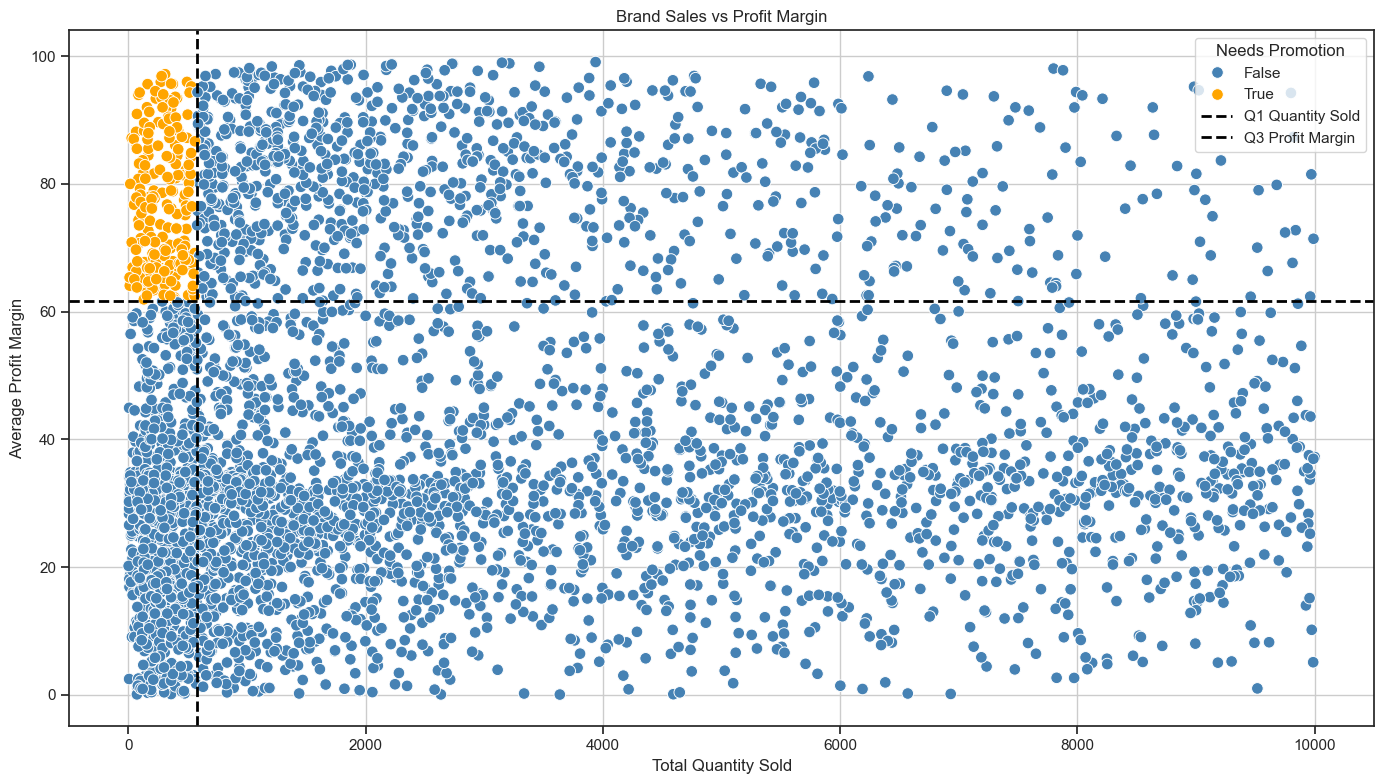

In [89]:
# filtering the data for better visualization
df_brand = df_brand[df_brand['Total_Selling_Price'] < 10000]

palette = {False: 'steelblue', True: 'orange'}

plt.figure(figsize=(14,8))
sns.scatterplot(data=df_brand, x='Total_Selling_Price', y='Profit_Margin', hue= df_brand['Brand'].isin(promo_brands['Brand']), palette=palette, s=70, edgecolor='white')

plt.axvline(x=q1_sales, color='black', linestyle='--', linewidth=2, label='Q1 Quantity Sold')
plt.axhline(y=q3_margin, color='black', linestyle='--', linewidth=2, label='Q3 Profit Margin')

plt.title('Brand Sales vs Profit Margin')
plt.xlabel('Total Quantity Sold')
plt.ylabel('Average Profit Margin')
plt.legend(title='Needs Promotion')
plt.grid(True)
plt.tight_layout()
plt.show()


- 	Which vendors and brands demonstrate the highest sales performances

In [90]:
top_vendor = df_clean.groupby('Vendor_Name')['Total_Selling_Price'].sum().nlargest(10)
top_brand = df_clean.groupby('Description')['Total_Selling_Price'].sum().nlargest(10)

def format_millions(value):
    if (value >= 1_000_000):
      return  f"{value / 1_000_000:.2f}M"
    if value >= 1000:
      return  f"{value / 1_000:.2f}K"
    else:
       return str(value)
    
top_brand = top_brand.apply(lambda x: format_millions(x))
top_vendor = top_vendor.apply(lambda x: format_millions(x))

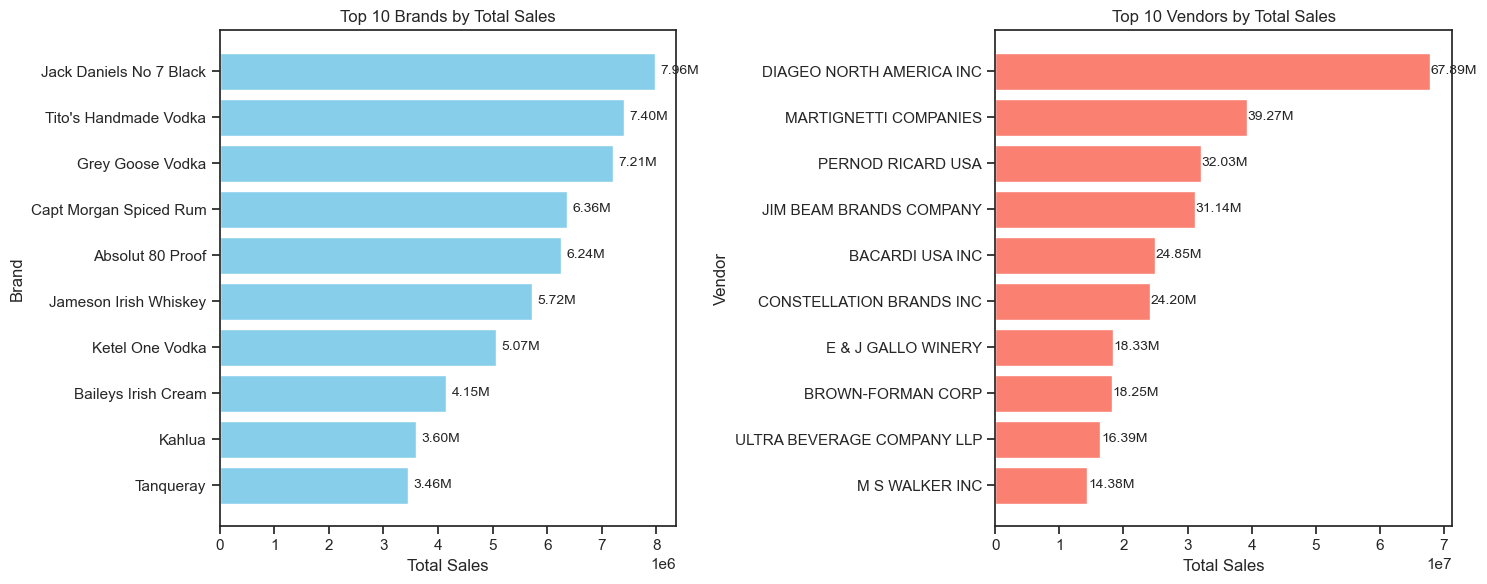

In [91]:
import matplotlib.pyplot as plt

# Backup numeric versions (before formatting)
top_brand_values = df_clean.groupby('Description')['Total_Selling_Price'].sum().nlargest(10)
top_vendor_values = df_clean.groupby('Vendor_Name')['Total_Selling_Price'].sum().nlargest(10)

# Plot
fig, ax = plt.subplots(1, 2, figsize=(15, 6))

# --- Brand Barplot ---
ax[0].barh(top_brand.index[::-1], top_brand_values.values[::-1], color='skyblue')
for i, label in enumerate(top_brand.values[::-1]):
    ax[0].text(top_brand_values.values[::-1][i] + 100000, i, label, va='center', fontsize=10)

ax[0].set_title('Top 10 Brands by Total Sales')
ax[0].set_xlabel('Total Sales')
ax[0].set_ylabel('Brand')

# --- Vendor Barplot ---
ax[1].barh(top_vendor.index[::-1], top_vendor_values.values[::-1], color='salmon')
for i, label in enumerate(top_vendor.values[::-1]):
    ax[1].text(top_vendor_values.values[::-1][i] + 100000, i, label, va='center', fontsize=10)

ax[1].set_title('Top 10 Vendors by Total Sales')
ax[1].set_xlabel('Total Sales')
ax[1].set_ylabel('Vendor')

plt.tight_layout()
plt.show()


- 	Which vendors contribute the most to total purchases 

In [92]:
vendor_performance = df_clean.groupby('Vendor_Name').agg({
  'Total_Cost_price':'sum',
  'Gross_Profit': 'sum',
  'Total_Selling_Price' : 'sum'
})

vendor_performance['percentage_Contribution'] = vendor_performance['Total_Cost_price'] / vendor_performance['Total_Cost_price'].sum()

vendor_performance = round(vendor_performance.sort_values('percentage_Contribution', ascending=False),2)

vendor_performance = vendor_performance.head(10)
vendor_performance['Gross_Profit'] = vendor_performance['Gross_Profit'].apply(format_millions)
vendor_performance['Total_Cost_price'] = vendor_performance['Total_Cost_price'].apply(format_millions)
vendor_performance['Total_Selling_Price'] = vendor_performance['Total_Selling_Price'].apply(format_millions)


vendor_performance['Cumalative_contribution'] = vendor_performance['percentage_Contribution'].cumsum()
vendor_performance

,Total_Cost_price,Gross_Profit,Total_Selling_Price,percentage_Contribution,Cumalative_contribution
Vendor_Name,,,,,
DIAGEO NORTH AMERICA INC,50.00M,14.13M,67.89M,0.16,0.16
MARTIGNETTI COMPANIES,25.44M,13.09M,39.27M,0.08,0.24
PERNOD RICARD USA,23.82M,6.72M,32.03M,0.08,0.32
JIM BEAM BRANDS COMPANY,23.22M,5.71M,31.14M,0.08,0.40
BACARDI USA INC,17.43M,6.07M,24.85M,0.06,0.46
CONSTELLATION BRANDS INC,15.26M,8.26M,24.20M,0.05,0.51
BROWN-FORMAN CORP,13.24M,4.25M,18.25M,0.04,0.55
E & J GALLO WINERY,12.01M,5.83M,18.33M,0.04,0.59
ULTRA BEVERAGE COMPANY LLP,11.07M,5.04M,16.39M,0.04,0.63


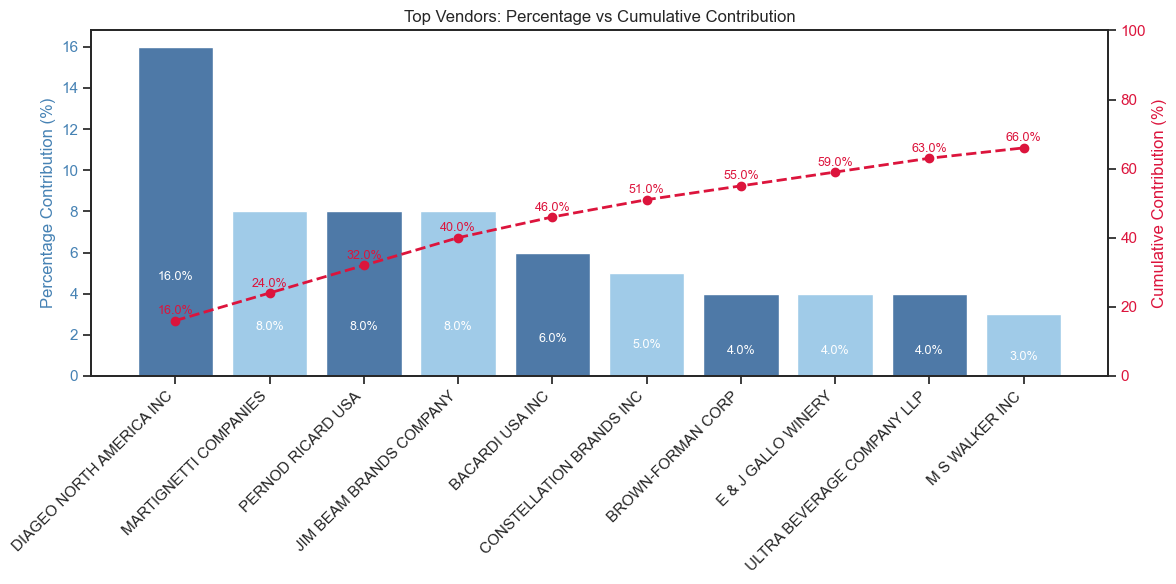

In [93]:
# Convert to percentage 
vendor_performance['percentage_Contribution'] *= 100
vendor_performance['Cumalative_contribution'] *= 100

vendors = vendor_performance.index.tolist()
bar_values = vendor_performance['percentage_Contribution'].tolist()
line_values = vendor_performance['Cumalative_contribution'].tolist()

fig, ax1 = plt.subplots(figsize=(12, 6))

# Bar Chart
bar_colors = ['#4E79A7' if i % 2 == 0 else '#A0CBE8' for i in range(len(vendors))]
bars = ax1.bar(range(len(vendors)), bar_values, color=bar_colors, label='Percentage Contribution')

# Set x-ticks and labels properly
ax1.set_xticks(range(len(vendors)))
ax1.set_xticklabels(vendors, rotation=45, ha='right')

ax1.set_ylabel('Percentage Contribution (%)', color='steelblue')
ax1.tick_params(axis='y', labelcolor='steelblue')

# Add data labels inside bars
for i, bar in enumerate(bars):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width() / 2, height * 0.3, f'{bar_values[i]:.1f}%', 
             ha='center', va='center', color='white', fontsize=9)

# Line Chart
ax2 = ax1.twinx()
ax2.plot(range(len(vendors)), line_values, '--o', color='crimson', linewidth=2, markersize=6, label='Cumulative Contribution')
ax2.set_ylim(0, 100)
# Add dot labels on the line
for i, value in enumerate(line_values):
    ax2.text(i, value + 1, f'{value:.1f}%', ha='center', va='bottom', color='crimson', fontsize=9)

ax2.set_ylabel('Cumulative Contribution (%)', color='crimson')
ax2.tick_params(axis='y', labelcolor='crimson')

# Title and layout
plt.title('Top Vendors: Percentage vs Cumulative Contribution')
fig.tight_layout()
plt.show()


-	How much of total procurement is dependent on the top vendors

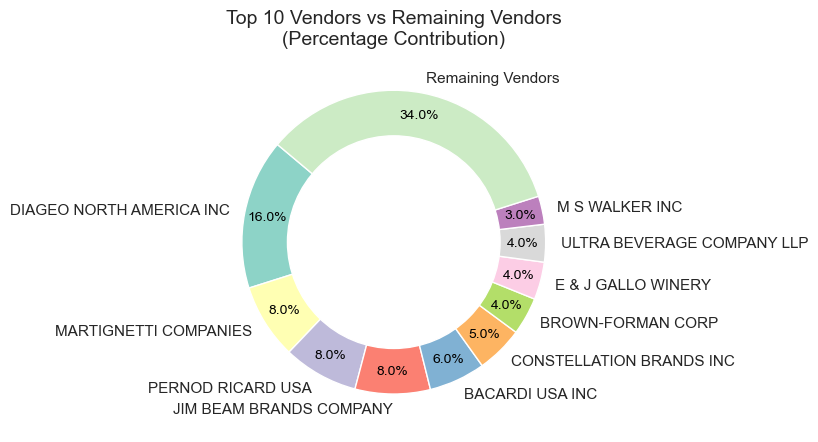

In [94]:
# Donut data: already top 10 + remaining vendors with actual float % values
donut_data = vendor_performance['percentage_Contribution'].copy()
remaining = 100 - donut_data.sum()
donut_data['Remaining Vendors'] = remaining

# Labels outside (vendor names)
labels = donut_data.index

# Plot
fig, ax = plt.subplots(figsize=(8, 8))
wedges, texts, autotexts = ax.pie(
    donut_data,
    labels=labels,
    autopct='%1.1f%%',  # Format inside the donut
    startangle=140,
    pctdistance=0.85,   # Distance of percentage inside
    labeldistance=1.1,  # Distance of vendor name outside
    colors=plt.cm.Set3.colors,  # Soft color palette
    wedgeprops=dict(width=0.4, edgecolor='white')
)

# Central circle for donut effect
centre_circle = plt.Circle((0, 0), 0.70, fc='white')
ax.add_artist(centre_circle)

# Title
ax.set_title('Top 10 Vendors vs Remaining Vendors\n(Percentage Contribution)', fontsize=14)

# Adjust text appearance
for autotext in autotexts:
    autotext.set_color('black')
    autotext.set_fontsize(10)

plt.tight_layout()
plt.show()


- Does purchasing in bulk reduce the unit price, and what is the optimal purchase volume for cost savings?

In [95]:
df_clean['Order_size'] = pd.qcut(df_clean['Quantity_purchased'], q=3, labels=['Small', 'Medium', 'Large'])
# Grouped data
avg_cost = df_clean.groupby('Order_size')['Cost_price'].mean().reindex(['Small', 'Medium', 'Large'])
avg_cost

C:\Users\singh\AppData\Local\Temp\ipykernel_652\2791481382.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_cost = df_clean.groupby('Order_size')['Cost_price'].mean().reindex(['Small', 'Medium', 'Large'])


Order_size
Small     39.435041
Medium    15.487545
Large     10.787083
Name: Cost_price, dtype: float64

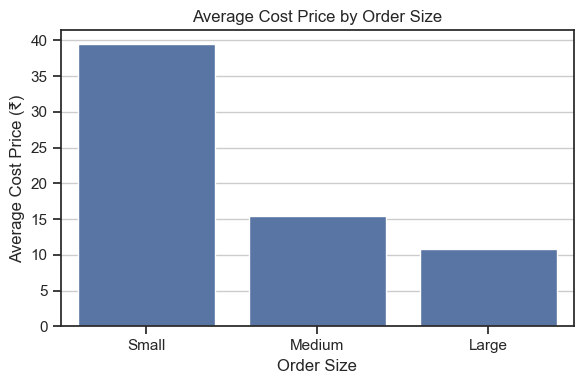

In [96]:
# Plot
plt.figure(figsize=(6, 4))
sns.barplot(x=avg_cost.index, y=avg_cost.values)  # Reversed for decreasing color
plt.title('Average Cost Price by Order Size')
plt.xlabel('Order Size')
plt.ylabel('Average Cost Price (₹)')
plt.grid(axis='y')
plt.tight_layout()
plt.show()


-	Which vendors have low inventory turnover, indicating excess stock and slow- moving products?	

In [97]:
df_clean[df_clean['Stock_turnover'] < 1].groupby('Vendor_Name')[['Stock_turnover']].mean().sort_values('Stock_turnover').head(10)

,Stock_turnover
Vendor_Name,
ALISA CARR BEVERAGES,0.615385
HIGHLAND WINE MERCHANTS LLC,0.708333
Circa Wines,0.755676
Dunn Wine Brokers,0.766022
CENTEUR IMPORTS LLC,0.773953
THE IMPORTED GRAPE LLC,0.807569
WALPOLE MTN VIEW WINERY,0.820548
BRONCO WINE COMPANY,0.822601
SOUTHERN GLAZERS W&S OF NE,0.825552


- How much capital is locked in unsold inventory per vendor, and which vendors contribute the most to it?

In [98]:
df_clean['Unsold_Inv_value'] = df_clean['Unsold_Inv'] * df_clean['Cost_price']

print('Total Capital Locked in Unsold Inventory', format_millions(df_clean['Unsold_Inv_value'].sum()))


Total Capital Locked in Unsold Inventory 2.47M


In [99]:
top_unsold_inv = df_clean.groupby('Vendor_Name')[['Unsold_Inv_value']].sum().sort_values('Unsold_Inv_value', ascending=False)
top_unsold_inv['Unsold_Inv_value'] = top_unsold_inv['Unsold_Inv_value'].apply(format_millions)
top_unsold_inv.head(10)

,Unsold_Inv_value
Vendor_Name,
DIAGEO NORTH AMERICA INC,696.58K
JIM BEAM BRANDS COMPANY,496.00K
PERNOD RICARD USA,459.91K
WILLIAM GRANT & SONS INC,400.08K
E & J GALLO WINERY,218.66K
BROWN-FORMAN CORP,177.65K
SAZERAC CO INC,169.97K
CONSTELLATION BRANDS INC,133.21K
MOET HENNESSY USA INC,126.48K


- What is the 95% confidence intervals for profit margins of top performing and low performing vendors.

In [100]:
high_threshold = df_clean['Total_Selling_Price'].quantile(.75)
low_threshold = df_clean['Total_Selling_Price'].quantile(.25)

top_vendor1 = df_clean[df_clean['Total_Selling_Price'] >= high_threshold]
bottom_vendor1 = df_clean[df_clean['Total_Selling_Price'] <= low_threshold]

# Function to calculate 95% confidence interval
def confidence_interval(data, confidence=0.95):
    data = data.dropna()  # Remove any NaN values
    n = len(data)
    mean = np.mean(data)
    sem = stats.sem(data)  # Standard error of the mean
    margin = sem * stats.t.ppf((1 + confidence) / 2, n - 1)
    return mean, (mean - margin, mean + margin)

# Apply to top and bottom vendors
top_mean, top_ci = confidence_interval(top_vendor1['Profit_Margin'])
bottom_mean, bottom_ci = confidence_interval(bottom_vendor1['Profit_Margin'])

print(f"Top Vendors Profit Margin:")
print(f"Mean: {top_mean:.2f}, 95% CI: {top_ci[0]:.2f} to {top_ci[1]:.2f}")

print(f"\nBottom Vendors Profit Margin:")
print(f"Mean: {bottom_mean:.2f}, 95% CI: {bottom_ci[0]:.2f} to {bottom_ci[1]:.2f}")


Top Vendors Profit Margin:
Mean: 27.58, 95% CI: 27.09 to 28.07

Bottom Vendors Profit Margin:
Mean: 40.12, 95% CI: 39.05 to 41.19


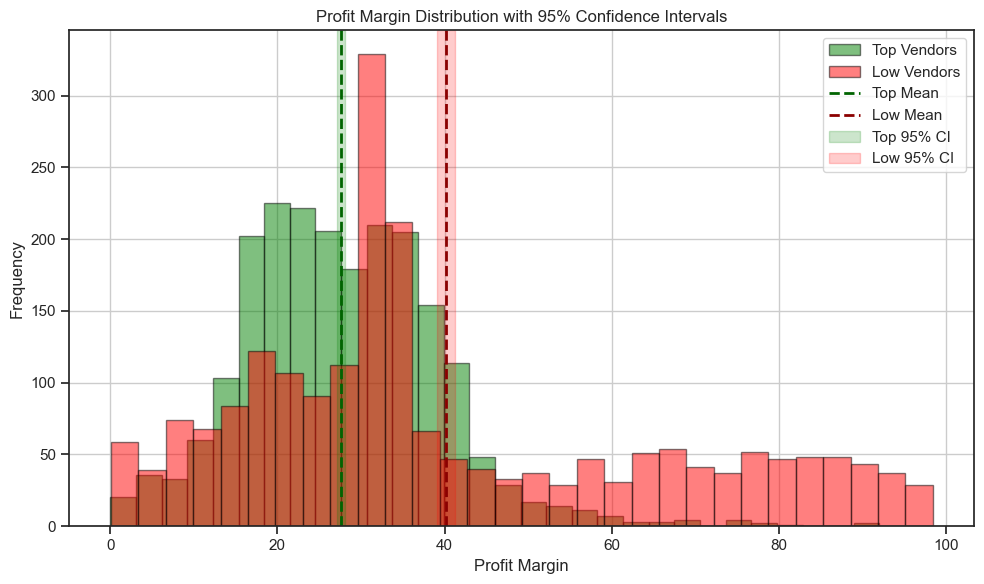

In [101]:
# Drop NaNs just for safe plotting
top_margin = top_vendor1['Profit_Margin'].dropna()
bottom_margin = bottom_vendor1['Profit_Margin'].dropna()

# Plot histogram
plt.figure(figsize=(10, 6))
plt.hist(top_margin, bins=30, alpha=0.5, label='Top Vendors', color='green', edgecolor='black')
plt.hist(bottom_margin, bins=30, alpha=0.5, label='Low Vendors', color='red', edgecolor='black')

# Mean lines
plt.axvline(top_mean, color='darkgreen', linestyle='--', linewidth=2, label='Top Mean')
plt.axvline(bottom_mean, color='darkred', linestyle='--', linewidth=2, label='Low Mean')

# Confidence intervals (pre-calculated)
plt.axvspan(top_ci[0], top_ci[1], color='green', alpha=0.2, label='Top 95% CI')
plt.axvspan(bottom_ci[0], bottom_ci[1], color='red', alpha=0.2, label='Low 95% CI')

# Labels and legend
plt.title('Profit Margin Distribution with 95% Confidence Intervals')
plt.xlabel('Profit Margin')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


- Is there a significant difference in profit margins between top performing and low performing vendors?

In [102]:
from scipy.stats import ttest_ind

# Drop missing values (if any)
top_margins = top_vendor1['Profit_Margin'].dropna()
bottom_margins = bottom_vendor1['Profit_Margin'].dropna()

# Perform independent t-test
t_stat, p_value = ttest_ind(top_margins, bottom_margins, equal_var=False)  # Welch's t-test

print(f"t-statistic: {t_stat:.2f}")
print(f"p-value: {p_value:.4f}")

# Interpretation
if p_value < 0.05:
    print("✅ Result: Significant difference in profit margins (reject H₀)")
else:
    print("❌ Result: No significant difference in profit margins (fail to reject H₀)")


t-statistic: -20.91
p-value: 0.0000
✅ Result: Significant difference in profit margins (reject H₀)
